In [1]:
import sys
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
sys.path.append('/home/ardelalegre/SoundMapping/Database')
from DatabaseAPI import DatabaseAPI
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from get_time_interval_data import *
from PCA import *
from Plot import *
import pickle
from sklearn.cluster import KMeans

In [2]:
# clean out NaNs and zeros
def extract_all_active_observations_v2(interval_matrix_data, array_indices):
    # exclude time column
    observations = interval_matrix_data[:,1:]
    selected_obs = np.hstack([observations[:,i*3:i*3+3] for i in array_indices])
    cleaned_data = []
    ind = []
    for i in range(selected_obs.shape[0]):
        if not any(np.isnan(selected_obs[i,:])) and not any(selected_obs[i,:]==0):
            cleaned_data.append(selected_obs[i,:])
            ind.append(i)
    selected_raw_obs = interval_matrix_data[ind,:]        
    return  np.vstack(cleaned_data), selected_raw_obs

In [3]:
def plot_time_series(data):
    # only plotting x
    length = data.shape[0]
    fig = plt.figure(figsize = [20,10])
    ax1 = fig.add_subplot(511)
    ax1.plot(data[:,1], label='array 0')  # array 0
    ax1.set_xlim(0,length)
    ax1.set_ylim(-1,1)
    ax1.legend()
    ax2 = fig.add_subplot(512)
    ax2.plot(data[:,4], label='array 1')  # array 1
    ax2.set_xlim(0,length)
    ax2.set_ylim(-1,1)
    ax2.legend()
    ax3 = fig.add_subplot(513)
    ax3.plot(data[:,7], label='array 2')  # array 2
    ax3.set_xlim(0,length)
    ax3.set_ylim(-1,1)
    ax3.legend()  
    ax4 = fig.add_subplot(514)
    ax4.plot(data[:,10], label='array 3') # array 3
    ax4.set_xlim(0,length)
    ax4.set_ylim(-1,1)
    ax4.legend()
    ax5 = fig.add_subplot(515)
    ax5.plot(data[:,16], label='array 5') # array 5
    ax5.set_xlim(0,length)
    ax5.set_ylim(-1,1)
    ax5.legend()
    plt.show()

## note
Different from previous static point experiments, two arrays are mounted onto the wall: array 0 and 1, and array 2, 3, 5 are mounted to the ceiling. 

In [4]:
chairs = get_time_interval_matrix_data("Dec 30 2020 12:15PM", "Dec 30 2020 12:20PM")

### uncleaned data time series

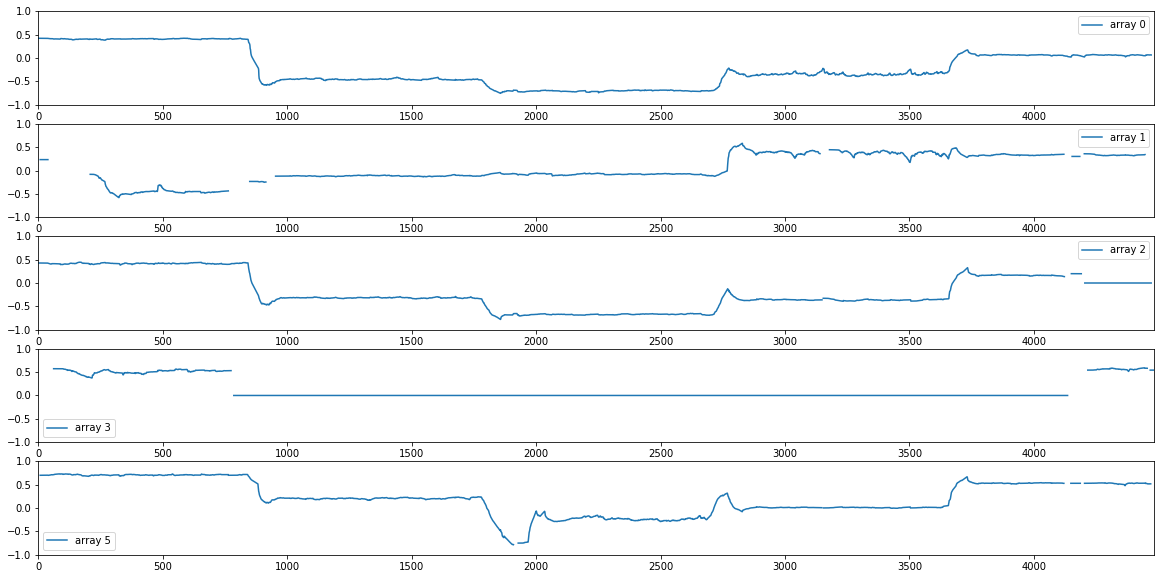

In [5]:
plot_time_series(chairs)

### Aim: To get raw data matrix and check whether for the array which has 0's, a channel other than channel 0 had some data.

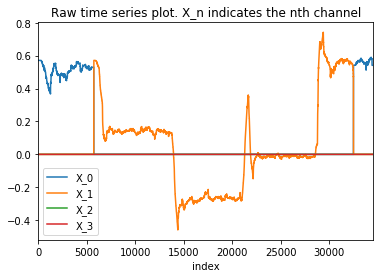

In [6]:
plot_raw_time_series("Dec 30 2020 12:15PM", "Dec 30 2020 12:20PM", 3)

### Stitching from table 2

In [7]:
# array 3
array_3_x = chairs[:,10]
array_3_y = chairs[:,11]
array_3_z = chairs[:,12]

# doing np.where == 0
array_3_x_0_indices = np.where(array_3_x==0)
array_3_y_0_indices = np.where(array_3_y==0)
array_3_z_0_indices = np.where(array_3_z==0)

In [8]:
# importing missing data from pickle
array_3_x_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/array_3_x_missing_data.p', 'rb'))
array_3_y_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/array_3_y_missing_data.p', 'rb'))
array_3_z_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/array_3_z_missing_data.p', 'rb'))

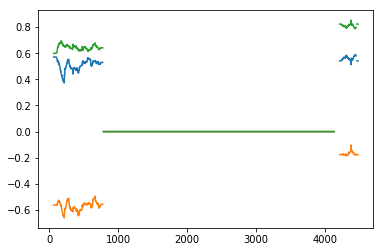

In [9]:
# plotting before stitching
plt.plot(array_3_x)
plt.plot(array_3_y)
plt.plot(array_3_z);

In [10]:
# padding before stitching
array_3_x_md_padded = np.pad(array_3_x_md, 1, mode = 'symmetric')

In [11]:
# figuring out the array to stitch back
array_3_x[array_3_x_0_indices] = array_3_x_md_padded
array_3_y[array_3_y_0_indices] = array_3_y_md
array_3_z[array_3_z_0_indices] = array_3_z_md

In [12]:
# stitching
chairs[:,10] = array_3_x
chairs[:,11] = array_3_y
chairs[:,12] = array_3_z

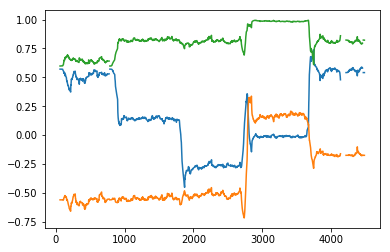

In [13]:
# after stitching
plt.plot(array_3_x)
plt.plot(array_3_y)
plt.plot(array_3_z);

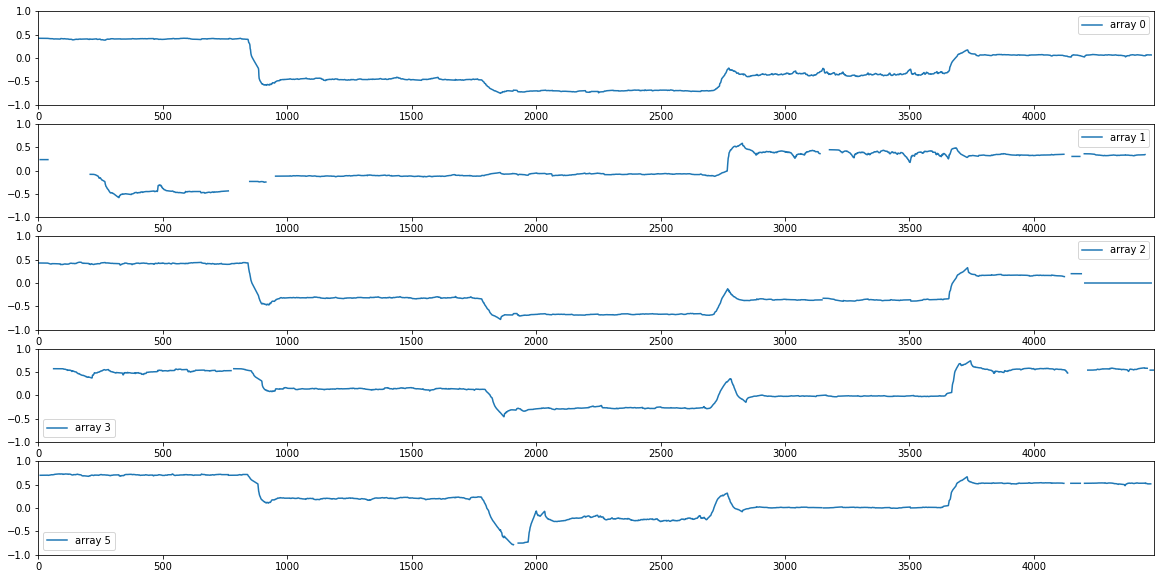

In [14]:
plot_time_series(chairs)

In [15]:
chairs_cleaned, chairs_og = extract_all_active_observations_v2(chairs, [0,1,2,3,5])

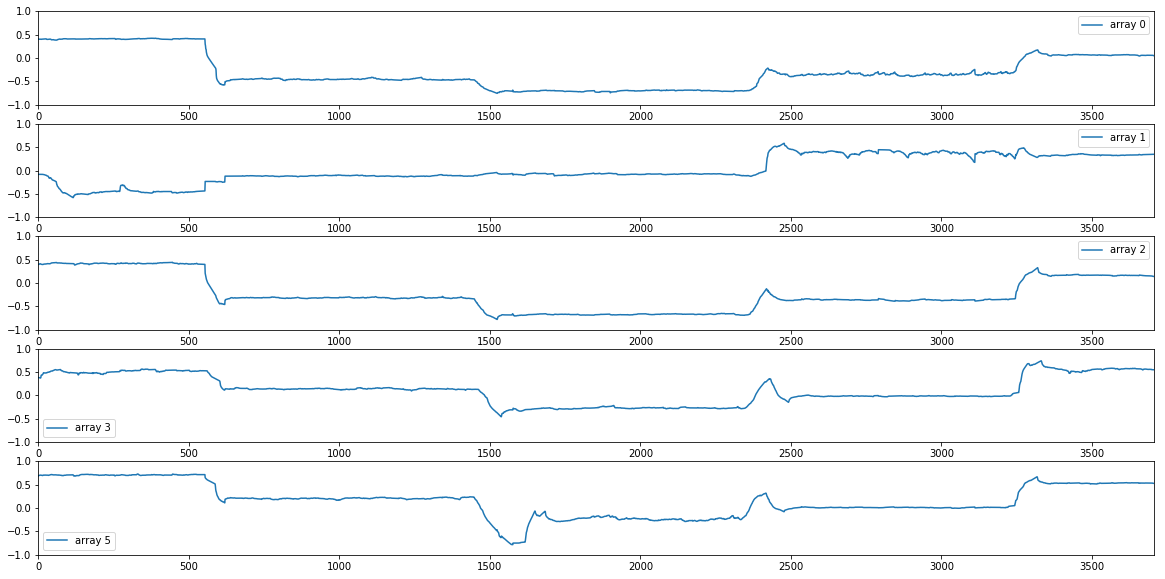

In [16]:
plot_time_series(chairs_og)

In [17]:
# Clean up the transitions
chair2 = chairs_og[100:550,:]
chair3 = chairs_og[650:1450,:]
chair4 = chairs_og[1700:2350,:]
chair5 = chairs_og[2500:3250,:]
chair1 = chairs_og[3350:,:]

In [18]:
chairs_cut = np.vstack([chair2, chair3, chair4, chair5, chair1])

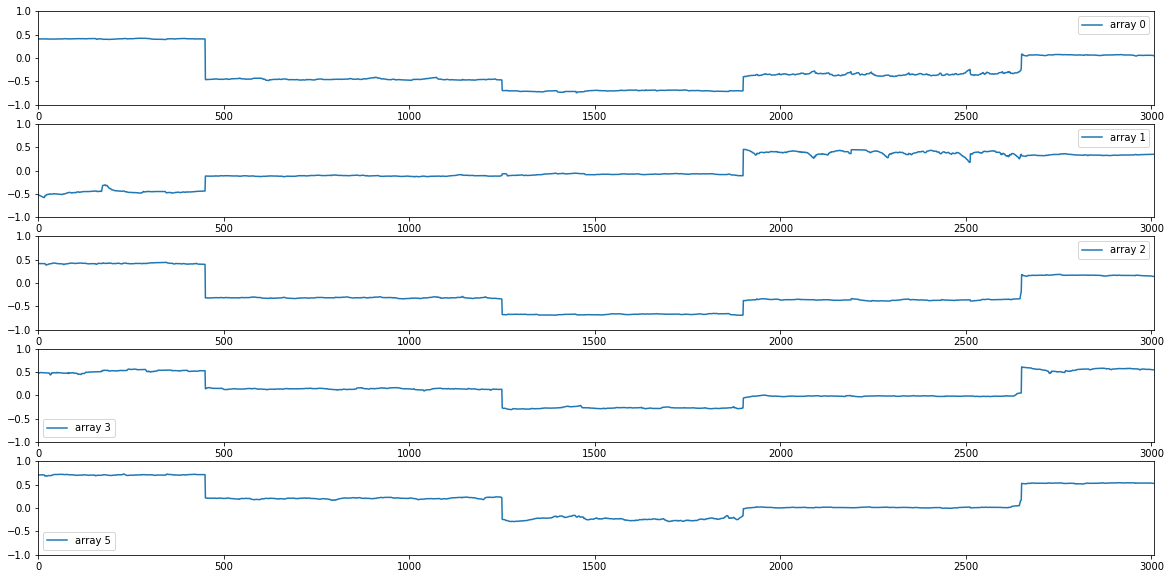

In [19]:
plot_time_series(chairs_cut)

In [20]:
chairs_cut_cdata = get_cdata(chairs_cut)
projections = project_to_eigen_vectors(chairs_cut_cdata, 2, EIGEN_VALUES_0819, EIGEN_VECTORS_0819)

/home/ardelalegre/SoundMapping/Analysis/Util/PCA.py:43: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data[:,1:],axis = 0,keepdims = True)


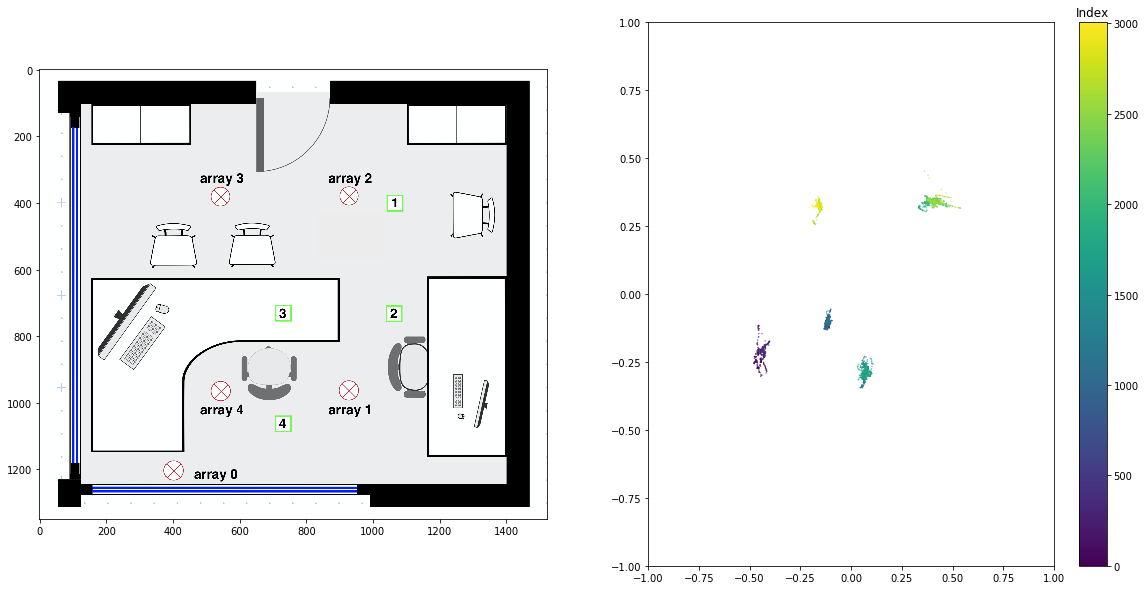

In [21]:
fig = plt.figure(figsize = [20,10])

ax2 = fig.add_subplot(121)
room_model_chair = plt.imread('room_model_v4.png')
ax2.imshow(room_model_chair)

ax = fig.add_subplot(122)
temp = ax.scatter(projections[:,0], projections[:,1], c = np.arange(projections.shape[0]), s=0.1)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
cbar = fig.colorbar(temp, ax=ax)
cbar.ax.set_title('Index')

plt.show()

### Calculate eigen vectors

In [22]:
eig_val, eig_vec = get_eigen_vectors(chairs_cut)

In [31]:
pickle.dump(chairs_cut, open('chairs_cleaned.p','wb'))

In [29]:
eig_vec

array([[-0.43349642,  0.27495556,  0.39057389, -0.03742823, -0.31376425,
        -0.20572038,  0.10528668, -0.1673914 ,  0.0486316 ,  0.27542519,
        -0.22545765, -0.1725862 ,  0.4513455 , -0.19962015,  0.01597643,
         0.        ,  0.        ,  0.        ],
       [ 0.16453434,  0.16959243,  0.08605369, -0.19733673, -0.19904958,
        -0.17737256,  0.48854573,  0.11654601, -0.17352328,  0.24203459,
        -0.08421957,  0.03779132, -0.21026199,  0.59317694, -0.28495085,
         0.        ,  0.        ,  0.        ],
       [ 0.04669912,  0.2382891 , -0.22393179,  0.14633468,  0.00750594,
        -0.36789529,  0.43997229, -0.18132541,  0.19780151, -0.56970191,
         0.2693233 ,  0.07297427,  0.23662152, -0.06366522, -0.0776622 ,
         0.        ,  0.        ,  0.        ],
       [ 0.23482871,  0.4071538 , -0.33535639, -0.54625097, -0.12507093,
         0.23350896, -0.15383027, -0.39800375, -0.15526823, -0.00774004,
        -0.00118549, -0.06171634,  0.14161181,  0.052

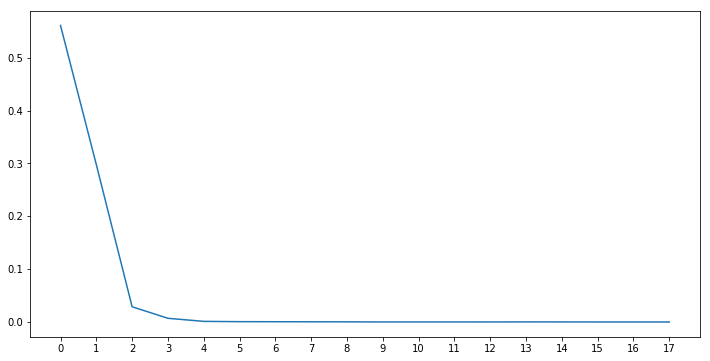

In [24]:
plt.figure(figsize = [12,6])
plt.plot(eig_val)
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 18, step=1))
plt.show()

In [25]:
eig_vec[:,1]

array([ 0.27495556,  0.16959243,  0.2382891 ,  0.4071538 ,  0.01347188,
       -0.06030014,  0.23641118,  0.36167394, -0.0969376 ,  0.20273907,
        0.4921134 ,  0.10262623,  0.        ,  0.        ,  0.        ,
        0.16247284,  0.33699439, -0.19848336])

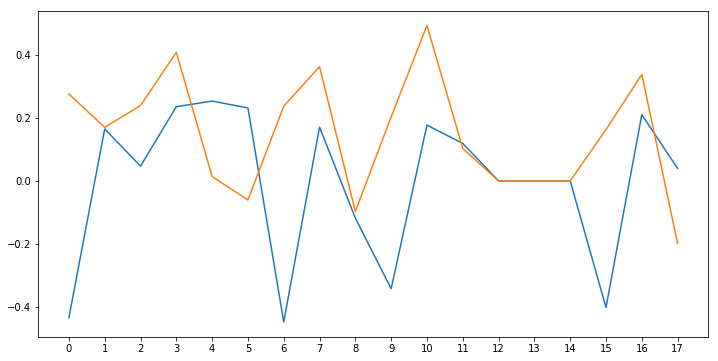

In [26]:
plt.figure(figsize = [12,6])
# plt.axvline(2)
# plt.axvline(6)
# plt.axvline(9)
# plt.axvline(12)
# plt.axvline(15)
plt.plot(np.arange(18),eig_vec[:,0])
plt.plot(np.arange(18),eig_vec[:,1])

locs, labels = plt.xticks()
plt.xticks(np.arange(0, 18, step=1))
plt.show()

In [27]:
chairs_cut_cdata = get_cdata(chairs_cut)
projections = project_to_eigen_vectors(chairs_cut_cdata, 2, eig_val, eig_vec)

array([[-1.51636756, -0.15141307],
       [-1.51773798, -0.15623069],
       [-1.52001325, -0.15861535],
       ...,
       [-0.53920659,  0.70146917],
       [-0.53454189,  0.70197638],
       [-0.53474266,  0.69860242]])

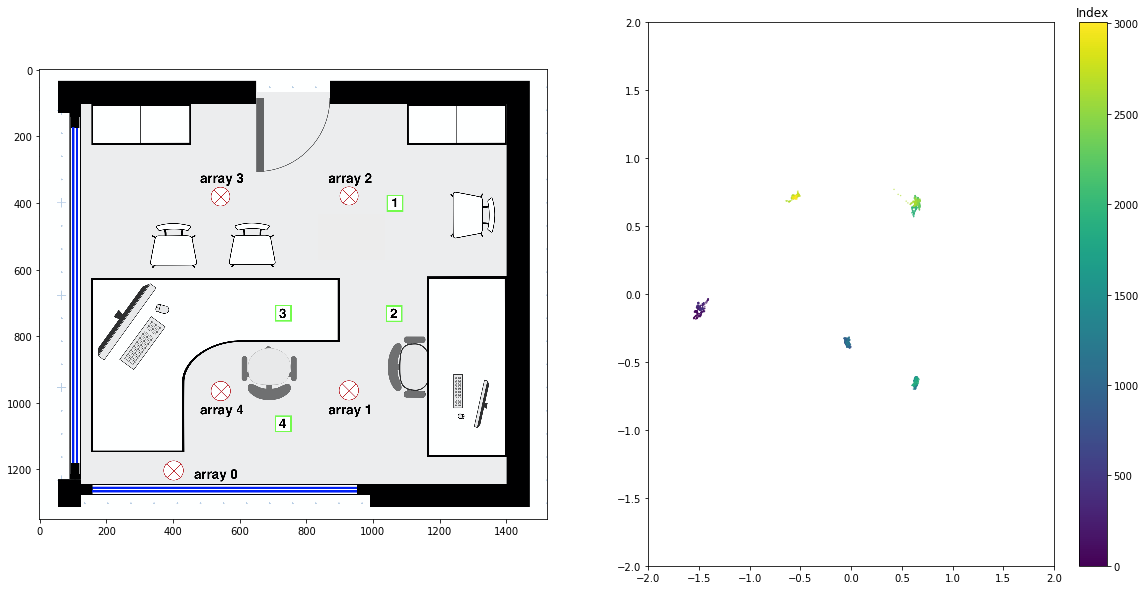

In [28]:
fig = plt.figure(figsize = [20,10])

ax2 = fig.add_subplot(121)
room_model_chair = plt.imread('room_model_v4.png')
ax2.imshow(room_model_chair)

ax = fig.add_subplot(122)
temp = ax.scatter(projections[:,0], projections[:,1], c = np.arange(projections.shape[0]), s=0.1)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
cbar = fig.colorbar(temp, ax=ax)
cbar.ax.set_title('Index')

plt.show()